# Optimising HIP kernels

The performance of HIP kernels is a complex **multi-dimensional optimisation problem**. It depends not only on efficient utilisation of hardware threads in compute units, but also on the timeliness and speed that memory is passed in and out of compute units. It is a general rule that vendor-specific libraries such as [rocBLAS](https://rocblas.readthedocs.io/en/rocm-5.6.1/) and [CuBLAS](https://developer.nvidia.com/cublas) are the **best way** to achieve optimal compute performance, however canned solutions are **not always available** for your chosen algorithm. At the same time, HIP implementations and their underlying hardware often have smart technologies built-in to optimise processing for commonly used computing operations. Sometimes the simplest approach works best! At other times better compute performance comes at a **significant increase** in the complexity of a program. When developer time is critical, a piece of code that performant but complex to understand may not be **ideal** for progress. While HIP is mostly targeted at using GPU's, there is a [CPU implementation](https://github.com/ROCm-Developer-Tools/HIP-CPU/) available, and CPU and GPU architectures are optimsed for different ways of computing. This means that a kernel that performs well on a CPU might perform poorly on a GPU, and vice-versa. **Experimentation is the key!** In the following sections we will explore the ways in which kernel performance can be impacted and try a number of strategies to increase performance for the matrix multiplication kernel.

## Compile software

### Linux, MacOS, and other Unices

In [1]:
!make

make: Nothing to be done for 'all'.


### Windows

In [2]:
#!nmake /f Makefile_win.mak

## Fundamentals of CPU and GPU architectures

It is helpful to first cover the fundamentals of computer architectures and explore differences between CPU's and GPU's. 

### Hardware threads and processing elements

From the introduction we have seen that that a processor is partitioned into compute units, and each compute unit provides a number of hardware threads that execute kernels. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/Intel-8th-Gen Core-3.jpg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A processor die showing an eighth-generation <span>Intel&trade;</span> <span>Core&trade;</span> processor. Image used with permission courtesy of Intel Corporation. </figcaption>
</figure>

Compute units (cores) have a clock cycle and can perform a limited number of instructions per cycle. During the execution of a program, instructions such as math commands are executed on the hardware threads, using memory that is passed in and out of the core from a hierarchy of caches. If this memory does not arrive on time, or get disposed of on time, then the hardware threads will stall and performance may be impacted. 

### Cache topics

#### Hierarchy

The fastest memory locations in a processor (CPU or GPU) core are the registers. They operate at or near the same clock speed as the core and are located on the processor die close to the hardware that performs compute operations. This memory is not cheap however, and memory for a computation is shuffled to and from the processor through a hierarchy of caches with the following sizes and locations:

* Register, fastest memory (few kB)
* L1 cache, fast on-die memory (tens of kB)
* L2 cache, fast on-die memory (hundreds of kB)
* L3 cache, fast memory near the device or on-die. (few MB to tens of MB)
* Global or device memory (RAM, few GB onwards)

The most frequently used memory is stored in the lowest level (L1, L2) caches. Memory that is not used as often is evicted to the slower (L2, L3) caches as necessary. Memory that is rarely used is flushed out to global memory.

#### Cache lines - the fundamental unit of memory transactions

Memory passed from caches doesn't arrive at a processor core in units of individual bytes, instead it arrives in transactional units called **cache lines**. Cache lines are around 64-128 bytes, which can store 16-32 floating point numbers.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/cache_line.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A cache line 64 bytes wide. </figcaption>
</figure>

This means that if a processor needs to fetch from or store a single value in memory, then the cache hierarchy must transport the **entire cache line** in which the value is located. Caches have slots in them where cache lines can be stored, however if a cache line is not in the faster caches, then it must be fetched from **main memory** at the cost of wasted processor cycles. 

> A key to achieving good performance with memory access is to **try and use as many neighbouring elements in cache line as possible** by subsequently fetching and storing memory that is in the immediate "neighbourhood" of a memory access. 

In the context of HIP, it is advantageous if neighbouring threads in a block access neighbouring memory locations. Then memory transfers can be shared among threads in what is known as **coalesced memory access**.

#### Latency

Latency is the number of cycles a processing element has to wait for memory to arrive from a cache. here are some indicative numbers on latency for CPU and GPU caches.

| Cache | memory latency (clock cycles on a CPU) | memory latency (clock cycles on a GPU)
|:----:|-----:|-----:|
|   Register  | ~1 | ~20 |
|   L1  | ~4 | ~30-100|
| L2 | ~8-12 | ~175-300 |
| L3 | ~24-40 | NA |
| Device memory | >= 100 | 300-800 | 

Sources for these numbers: [GPU numbers 1](http://lpgpu.org/wp/wp-content/uploads/2013/05/poster_andresch_acaces2014.pdf), [GPU numbers 2](https://arxiv.org/pdf/1804.06826.pdf), [CPU numbers 1](http://techreport.com/review/27018/intel-xeon-e5-2687w-v3-processor-reviewed/4), [CPU numbers 2](https://www.anandtech.com/show/16529/amd-epyc-milan-review/4).

From this table we can see that the memory latency for GPU is orders of magnitude slower than for CPU's. GPU vendors get around this problem by having **deep execution pipelines** with many teams of threads active per processor core. If one team stalls while waiting for memory, another team can take over. It is therefore desirable to have as many teams ready to take over as a compute unit will support. The ratio of active teams to the maximum number of teams on a compute unit is called **occupancy**. It is desirable to achieve a high degree of occupancy for a kernel.

#### Throughput

Throughput is a measure of how fast memory can be transported from a cache to the processing element. As follows is a rough guide on what one can expect to see from CPU and GPU cache throughput.

| Cache | speed (GB/s on a CPU) | speed (GB/s on a GPU) |
|:----:|-----:|-----:|
|   L1  | 2000-4000 | ~1000+ |
| L2 | 1000-1500 | ~1000 |
| L3 | 500-1000 |NA|
| Device memory | 16 - 128 | 100-1200 |

Sources for these numbers: [CPU numbers](http://www.tested.com/tech/457440-theoretical-vs-actual-bandwidth-pci-express-and-thunderbolt), [GPU numbers](http://meseec.ce.rit.edu/551-projects/spring2015/3-2.pdf)

#### Thoughts on latency and throughput with HIP kernels in mind

With either CPU or GPU compute units we must make sure to make best use of cache lines. This means creating blocks whose neighbouring threads also work on neighbouring elements of a memory allocation. It seems that throughput from global memory is significant faster on a GPU device, however memory will take more cycles to arrive. 

### CPU architecture specifics

CPU's usually have fewer than 100 compute units (cores), and each compute unit has sophisticated instruction handling and nice things like pre-emptive memory fetching and branch prediction. One can think of CPU compute units as **smart workers**, and the cache latency timings above indicate CPU's are more nimble than GPU's. The compute units in a CPU each provide a number of hardware threads that can execute instructions independently of each other. CPU's have registers, and on-die L1 and L2 caches. The L3 cache is usually also on-die, but is in an area that is commonly accessible to other compute units. In <span>AMD&trade; Zen&trade; 3+</span>  CPU's the compute units are grouped into chiplets of 8 cores called core complexes (CCX's), and an L3 cache on the chiplet services all 8 cores. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:80%">
    <img style="vertical-align:middle" src="../images/cpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Section of a CPU processor, showing Compute Units (cores), each with floating point SIMD units and integer pipelines. </figcaption>
</figure>

In terms of math operations, CPU's have integer processing and SIMD (Single Instruction Multiple Data) math units that can perform operations on vectors of numbers **with one instruction**. At the time of writing, vectors of up to 8-16 floats (AVX2-AVX512) may be processed at a time using the SIMD units of a CPU. It depends largely on what kind of vector instructions are supported by the chipset.

> Getting good floating point performance from a CPU is **critically** dependent on wether or not one can effectively leverage the SIMD units of the CPU. Using **vectors** is a way to provide strong hints the to implementation's device compiler to emit vector instructions that work on the CPU.

#### Example specifications

Here are some specifications of CPU's for Pawsey's previous generation supercomputer Magnus, and the latest supercomputer Setonix.

| Computer | CPU | Peak clock frequency (GHz) | Cores | Hardware threads | L1 Cache (KB) | L2 Cache (KB) | L3 cache (MB) | FP SIMD width (bits) | Peak TFLOPS (FP32 calculated) |
|:----:|:----:|-----:| -----: | -----: | :----: | :----: | :----: | :----: | :----: |
| Magnus | Intel Xeon 2690 v3 | 3.5 | 12 | 24 | 12x32 | 12x256 | 30 | 256 | 0.34 |
| Setonix |AMD EPYC 7763 | 3.5 | 64 | 128 | 64x32 | 64x512 | 8x32 | 256 | 1.8 |

Source for the CPU specs [Xeon](http://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E7-4850%20v4.html) and [Epyc](https://en.wikipedia.org/wiki/Epyc).

### GPU architecture specifics

There is some confusing terminology on what exactly is a processor core in GPU's. Like CPU's, GPU's also have compute units, called **Streaming Multiprocessors** in NVIDIA terminology, **Compute Units** in AMD terminology, and **Xe-Cores** in Intel terminology. Each of these compute units schedule instructions, move data in the caches, and can be considered the **actual cores** in a GPU processor. 

Instructions issued by the compute units are executed by hardware threads over a **team** of SIMD-like math units (lanes in the team) that perform physical operations on data in **lock-step** with other units (lanes) in the team. These units are called **CUDA Cores** in NVIDIA terminology, and **Shader Cores** in AMD terminology. On NVIDIA hardware, teams are 32-64 lanes wide and are known as **warps**, and on AMD hardware teams are 64 lanes wide and are known as **wavefronts**. The diagram below shows the layout of lanes for compute units.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:100%">
    <img style="vertical-align:middle" src="../images/gpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Floating point units (FP32), registers, and caches for different GPU's. </figcaption>
</figure>

The confusing part is that in HIP/CUDA software terminology, a software **thread** in a block is that which runs an instance of a kernel. Instructions in that kernel instance are physically executed by a math unit in a lane of a warp or wavefront. Therefore a lane of a hardware thread team is what executes instructions in a kernel by software thread. One or more thread teams may particpate in a block, and therefore an efficient choice for the number of threads in a block is naturally a **multiple** of the team size. The **warpsize** field of a **hipDeviceProp_t** structure from a call to **hipGetDeviceProperties** will inform you how many lanes are in a thread team.

#### SIMT and how it differs from SIMD

The model discussed above for executing instructions in lock-step over thread teams is known as SIMT (Single Instruction Multiple Threads). As with SIMD, each hardware thread executes the same instruction over every lane in the team. The crucial distinction between SIMD and SIMT is that each lane of a thread team has a degree of self determination. Each lane has access to its own data and the ability to execute a divergent code path. However since lanes in a team execute in lock-step with each other, all the threads in the team **must** participate in **every** code path. Results from lanes that do not contribute to the output are masked out. It is therefore good for performance to keep path divergence to a minimum.

In summary, for SIMD a single vector instruction **must apply to all elements** of a vector and no path divergence is possible. SIMT allows for a limited amount of divergence.

#### Lightweight thread switching 

A compute unit can switch between hardware thread with **minimal overhead**, so it can switch to a hardware thread whose team is ready to execute instructions, while other hardware threads wait for memory to arrive. 

#### Example specifications for supercomputing GPU's

Here are some specifications on more recent GPU's for supercomputing. NVIDIA has separate math units for 32-bit and 64-bit floating point instructions. AMD has a more SIMD-like approach to computing floats, which means that on the MI200 architecture a 64-bit floating point arithmetic can proceed at the same rate as 32-bit math.

| Card | Boost clock (GHz)| Compute Units | FP32 Processing Elements | FP64 Processing Elements (equivalent compute capacity) | L1 Cache (KB) | L2 Cache (KB) | device memory (GB) | Peak Tflops (FP32)| Peak Tflops (FP64)|
|:----:|:-----| :----- | :----- | :---- | :---- | :---- | :---- | :---- | :---- |
| NVIDIA Tesla K40 | 0.875 | 15 | 2880 | 960 | 48 | 1536 | 12 |5.04|1.68|
| NVIDIA Tesla M60 |1.178 |32| 4096| NA | 32x2x48 | 3072 | 8 |4.8|0.151|
| NVIDIA Tesla P100 |1.480| 56 | 3584 | 1792 | 56x64| 4096 | 16 |10.6|5.3|
| NVIDIA Tesla V100 |1.530| 80 | 5120 | 2560 | 80x96 | 6144 | 16 |15.7|7.8|
| NVIDIA Tesla A100 |1.410| 108 | 6912 | 3456 | 108x164 | 40960 | 40 |19.5|9.7|
| AMD Radeon Instinct MI6 |1.233| 36 | 2304 |  | 36x16 | 2000 | 16 |5.73|0.358|
| AMD Radeon Instinct MI8 |1.000| 64 | 4096 |  | 64x16 | 2000 | 4 |8.2|0.512|
| AMD Radeon Instinct MI25 |1.501 | 64 | 4096 |  | 64x16 | 4000 | 16 |12.3 |0.768|
| AMD Radeon Instinct MI50 |1.746 | 60 | 3840 |  | 60x16 | 4000 | 16 |13.4 |6.7|
| AMD Radeon Instinct MI100 |1.502 | 120 | 7680 |  | 120x16 | 8000 | 32|23.1 |11.5|
| AMD Radeon Instinct MI200 |1.7 | 208 | 13312 |  | 208x16 | 16000 | 128 | 45.3 | 45.3 |
| AMD Radeon Instinct MI250x |1.7 | 220 | 14080 |  | 220x16 | 16000 | 128 | 47.9 | 47.9 |

Source for these numbers [Acceleware](https://training.acceleware.com/blog/Tesla-Meets-Maxwell), [NVIDIA](https://devblogs.nvidia.com/inside-volta/), [AMD](https://www.amd.com/en/graphics/servers-radeon-instinct-mi), [Microway](https://www.microway.com/knowledge-center-articles/in-depth-comparison-of-nvidia-tesla-maxwell-gpu-accelerators/), and [TechPowerup](https://www.techpowerup.com/gpudb/2760/tesla-m60).

#### Occupancy

GPU vendors overcome memory latency shortcomings by having **deep execution pipelines**, meaning that multiple teams (warps or wavefronts) can be active (in the process of executing instructions) on a compute unit at any one time. A block can have more than one thread team in it and a compute unit can switch focus between thread teams in blocks **with minimal overhead**, to hide latencies while memory is being fetched. Naturally one would want as many thread teams active as possible, and **Occupancy** is a term used to describe the ratio of how many teams **are active** vs how many **can be** active. Full occupancy is generally good for performance, but there are a number of limits that can impact occupancy, such as the following:

* limits on blocks per compute unit
* limits on the number of thread teams per compute unit
* limits on threads per block
* limits on threads per compute unit
* limits on registers per compute unit
* limits on registers per block
* limits on shared memory per compute unit
* limits on shared memory per block

If the number of software threads in a block is too low, then occupancy is reduced by the limit of permissible blocks per compute unit. If it is too large then you either might not be able to schedule a kernel, or synchronisation between thread teams becomes time consuming. If each thread uses too many registers or the block uses too much shared memory then that can reduce performance, through either limiting occupancy or spilling over into global memory at the price of greater latency. Sometimes occupancy is simply limited by not having enough parallel work scheduled to keep a sufficient number of work items busy.

Some tips for maximising occupancy are then:

* Schedule blocks whose number of threads are a multiple of thread team size.
* Keep the number of private variables low
* Keep the shared memory usage low
* Keep the workload consistent across workgroups
* If possible schedule enough work so that every compute unit in the GPU can achieve full occupancy.

##### Example

For the matrix multiplication algorithm as it stands, we are using a small number of private variables and we have one work item for every element in matrix C. For a matrix size of $1024^{2}$ there can be just over $1,048,576$ or threads (kernel invocations). From this [source](https://gpuopen.com/learn/amd-lab-notes/amd-lab-notes-register-pressure-readme/#:~:text=This%20means%20that%20the%20physical,the%20most%20common%20occupancy%20limiters.) the maximum number of wavefronts each compute unit may have active at any one time is 32. Since there are 110 compute units in MI250x GCD there can be 110x32x64 = 225,280 threads active at any one time on a MI250x.

From the occupancy table in [NVIDIA Nsight Compute](https://developer.nvidia.com/nsight-compute) an NVIDIA RTX 3060 with CUDA compute capability 8.6 can have 1,536 threads (48 warps) active per streaming multiprocessor active at any one time. Since there are 28 streaming multiprocessors then 28x1536 = 43,008 work items may be active at any one time. 

Therefore we know there is more than enough work scheduled to keep the streaming multiprocessors busy. In the default matrix multiplication algorithm there is no shared memory usage and very little register usage, so we anticipate that the GPU can sustain full occupancy with the right block size.

#### Instruction branching in GPU kernels (thread divergence)

Work-items in thread teams on GPU's execute instructions in **lock-step** with each other. One needs to be careful then to avoid building kernels where individual work-items execute different (and lengthy) code paths, because then the whole team has to visit each code path. For example the following kernel code is not ideal because work-items with even-numbered worker_id's execute work package 1 while the odd-numbered workers are masked out, then the odd-numbered threads in the team execute work package 2 while the even threads are masked out. In either case the team as a whole must visit every code path together, which degrades performance on GPU's.

```C++
    size_t worker_id = get_local_id(0);
    
    if (worker_id % 2 == 0) {
    
        // Work package 1
    
    } else {
        
        // Work package 2
    
    }
    ...
```

#### Matrix and tensor core availability in HIP

Up to this point I have completely skipped over the extra matrix (AMD, INTEL) and tensor (NVIDIA) core functionality present in modern GPU's. This special matrix processing machinery has applications in machine learning and deriving the very best performance out of your hardware. On AMD and NVIDIA hardware these instructions are accessed through vendor-specfic instructions. The use of these instructions comes at the expense of HIP portability, however in your kernel you can use an `#ifdef` with macros such as `__HIP_PLATFORM_NVIDIA__` or `__HIP_PLATFORM_AMD__` to work out which vendor instruction to use.

## Strategies to optimise the use of your compute devices

With this hardware background in mind we can go about exploring ways to improve performance in kernels. The matrix multiplication example is a trial algorithm we can use to see how specific techniques respond.

### Floating point operations

Math operations (such as multiply or add) on floating point numbers are an essential component of scientific applications. These operations are typically performed on 32- or 64-bit numbers, however 16-bit operations are becoming popular in machine learning as those do not require extremely precise calculations. Performance of a processor is measured in FLOPS, or the total number of floating point operations its compute units can perform in one second. At the time of writing units of gigaFLOPS ($10^{9}$), teraFLOPS ($10^{12}$), petaFLOPS ($10^{15}$), and exaFLOPS ($10^{18}$) are commonly used to describe compute device performance.

The raw floating point performance of a compute device is very much dependent on precision and wether or not the architecture is built for it. Gaming hardware is often optimised for 32-bit floats, and 64-bit processing may be emulated in software or accomplished with fewer cores. For example the RTX 3060 graphics card has a 64-bit floating point processing rate that is **64 times lower** than 32-bit due to having 64 times fewer 64-bit capable processing elements. CPU's have SIMD processing units that can process vectors of floats with a single instruction. At the time of writing vectors of up to 512 bits (16 floats) can be processed by AVX-512 instructions.

Compute performance within a kernel is also determined by the type of math instruction performed. Addition, multiplication, and fused multiply-add are among the **cheapest** operations to perform (costing a few processor cycles), whereas division, square-root, and trigonometric functions are typically an **order of magnitude** more expensive. Writing your kernels to minimise expensive math operations will help, however waiting for memory is time consuming, and during those times kernel math can often be done for free.

### Arithmetic intensity and working out where to spend the effort

The **Arithmetic intensity** is the ratio of FLOPS computed per Byte transferred. It helps us gauge if an algorithm is likely to be constrained by bandwidth or floating point performance. For our problem matrix A is of size ($N_{0,C}, N_{1,A}$) and B is of size ($N_{1,A}, N_{1,C}$). Every element of matrix C requires $N_{1,A}$ loads from A, $N_{1,A}$ loads from B, and 1 store to C. It also requires $N_{1,A}$ multiplications and $N_{1,A}$ additions. The arithmetic intensity of matrix multiplication is then

$$ a = \frac{2N1_A}{(2N1_A+1)b} $$

where **b** is the number of bytes stored per element. When $N1_A$ is large the arithmetic intensity for matrix multiplication is

$$ a \approx \frac{1}{b}. $$

If a processor has a peak floating point performance of $F_{P}$ FLOP/second, and a particular cache can feed that processor at a peak bandwidth of $B_{P}$ bytes/second then we can calculate a floating point limit that is dependent on memory bandwidth.

$$F_{B} = a  \frac{\mbox{FLOP}}{\mbox{byte}} B_{P}\frac{\mbox{byte}}{\mbox{second}} = a B_{P} \frac{\mbox{FLOP}}{\mbox{second}}$$ 

The actual attainable floating point performance will be either $F_{B}$ or $F_{P}$, whatever is lower. If we set $F_{B} = F_{P}$ then we can solve for the crossover point in arithmetic intensity.

$$a_{0}=\frac{F_{P}}{B_{P}}$$

Therefore the limits (or roofline) on performance is as follows:  

$$
F = \left \{
\begin{array}{rl}
aB_{P} & \mbox{if} \space a<\frac{F_{P}}{B_{P}},\\
F_{P}& \mbox{otherwise}
\end{array}
\right .
$$

For example, the AMD Mi250x GPU processor has a peak 32-bit floating point processing rate of $F_{P} = 47.9$ TFLOPS and a peak memory bandwidth of $F_{B}=3.2$ TB/s from global memory. Problems will be constrained by memory bandwidth up to an arithmetic intensity of 

$$a_{0}=\frac{47.9}{3.2} \approx 15$$

for more information see the [Wikipedia Article on Roofline Models](https://en.wikipedia.org/wiki/Roofline_model).

Usually the arithmetic intensity for processors is much larger than $\frac{1}{b} $. Boosting the FB ratio for matrix multiplication through reducing $b$ is a way forward for getting better performance. Some thoughts on this are as follows:

* We are not going to get anywhere near the rated peak performance of the compute device. That's usually a safe assumption!
* Optimising memory transfers is where we should concentrate our efforts.
    * Lowering the precision of data will increase the FB ratio.
    * Find optimal block sizes that balance occupancy and workgroup size and the size of memory requests. 
    * Try to reuse information in lower level caches.
    * Rearrange memory access patterns to access memory in a contiguous way.
* We can likely get most of compute operations done during memory transfers.
* We need good occupancy so the GPU can switch to another workgroup while waiting for memory.
* Speedups over a CPU implementation are more likely to be limited to the difference in memory bandwidth speeds.

### Testbench setup

In this workbook we are going to try a number of strategies to optimise matrix multiplication. Performance of a kernel is a non-linear function of the block size, therefore for fairness on each strategy it is important to find the **global minimum** in runtime for the landscape of possible choices for block sizes.

In <a href="../include/hip_helper.hpp">hip_helper.hpp</a> is a function called **h_optimise_block** that takes in a set of N block size experiments in a file called **input_block.dat** (of size (N, 3) and type **uint32_t**), collects kernel timing statistics for each experiment, and writes the output to **output_block.dat** (of size (N,2) and type **double**) with dimension 1 containing the mean and standard deviation of kernel runtimes. There are a number of different implementations of matrix multiplication in this directory. Each has been set up to use **h_optimise_local** to read **input_block.dat** and write to **output_block.dat** . The file [benchmark.py](benchmark.py) constructs **input_block.dat** for each implementation, runs the experiment, and collects the timing results into a file called **benchmark.json**. 

The matrix sizes for **A**, **B**, and **C** for the test was $1024^2$, which might be different than is contained in the file [mat_size.hpp](mat_size.hpp) which governs the size at compile time. We have pre-collected timing results for each strategy using 1 GPU on Setonix, and the results are in the sub-directory [benchmarks/setonix.json](benchmarks/setonix.json).  The following code loads these benchmarks and constructs a validation test. 

In [3]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))
import subprocess
import json
import py_helper

%matplotlib widget

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

# Construct validation tests
mat_mul_double=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float64)
mat_mul_float=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float32)

# Make up objects for timing results and local optimisation
timings=py_helper.TimingResults()
local_opt=py_helper.LocalOpt()

# Load the Setonix benchmark
benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "setonix.json"))
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "laptop.json"))
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "workstation.json"))
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmark.json"))

gpu_id=0

# Print the benchmarks
print("Keys in benchmark")
for key in benchmark:
    print(f"\"{key}\"")

Keys in benchmark
"Double precision (GPU)[0]"
"Single precision (GPU)[0]"
"Shared A (GPU)[0]"
"Shared B (GPU)[0]"
"Transpose B (GPU)[0]"
"Transpose A (GPU)[0]"
"Tile shared AB (GPU)[0]"
"Tile shared AB vector (GPU)[0]"
"Tile shared A (GPU)[0]"
"Tile shared A vector (GPU)[0]"
"Tile shared B (GPU)[0]"
"Tile shared B vector (GPU)[0]"
"HIPBlas (GPU)[0]"


### Data precision

In scientific computing the precision and range of 64-bit arithmetic can be important, for example in the solution of sensitive differential equations. Compute hardware is often optimised for 32-bit floats, and if your algorithm supports it you might gain a speedup by running at lower precision. In the example below we run a matrix multiplication problem at 64-bit and 32-bit precision to see how much of a difference it makes to kernel execution.

#### Matrix multiplication with 64-bit precision

Let's validate matrix multiplication with the full 64-bit precision GPU implementation.

Device id: 0
	name:                                    NVIDIA GeForce RTX 3060 Laptop GPU
	global memory size:                      6226 MB
	available registers per block:           65536 
	maximum shared memory size per block:    49 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
Time for kernel was 1.475 ms
Maximum error (infinity norm) is: 8.52651e-14


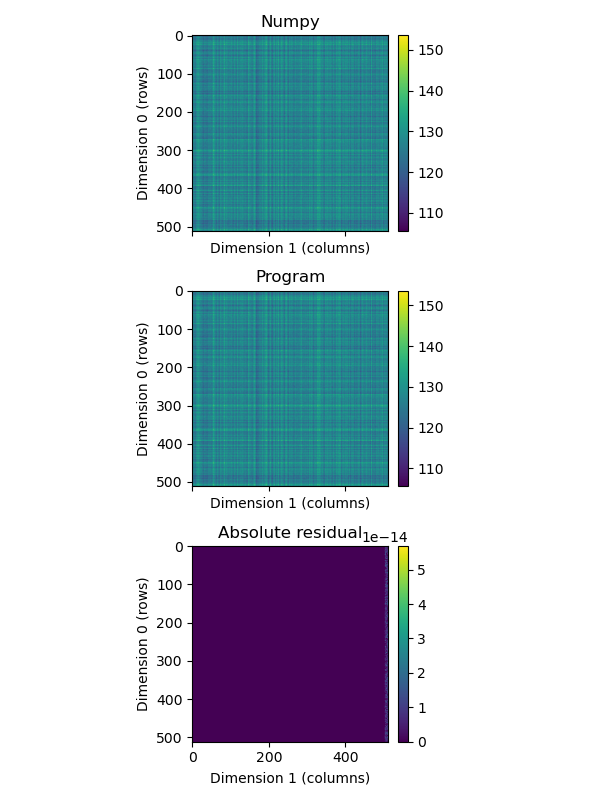

In [4]:
subprocess.run(["./mat_mult_double.exe"])
mat_mul_double.load_data()
mat_mul_double.check_data()

At full precision we are getting the same results as Python, which natively does matrix operations in 64 bit.

#### Matrix multiplication with 32-bit floats

Now lets drop to a lower precision. As this problem is memory bound, we expect single precision to be faster as there is less memory to transfer, and compute devices can often crunch 32-bit numbers much faster than 64-bit.

Device id: 0
	name:                                    NVIDIA GeForce RTX 3060 Laptop GPU
	global memory size:                      6226 MB
	available registers per block:           65536 
	maximum shared memory size per block:    49 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
Time for kernel was 0.432 ms
Maximum error (infinity norm) is: 4.57764e-05


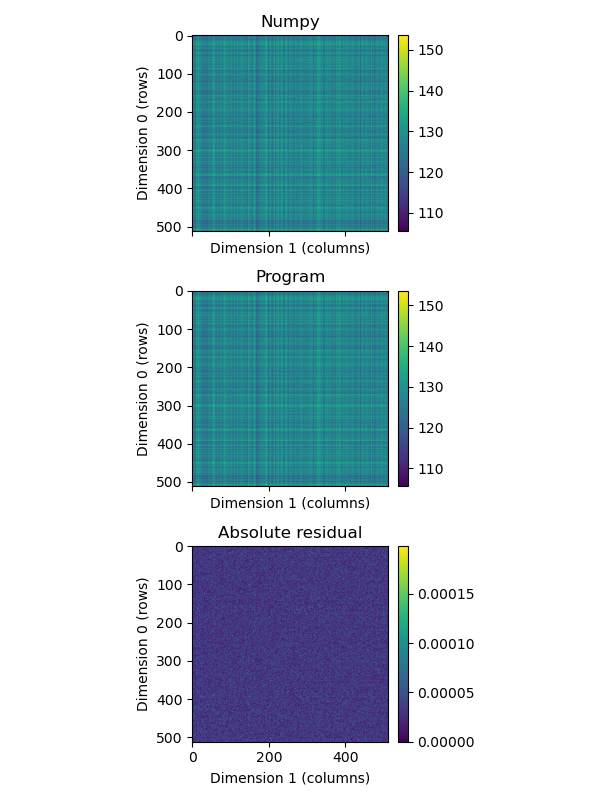

In [5]:
subprocess.run(["./mat_mult_float.exe"])
mat_mul_float.load_data()
mat_mul_float.check_data()

The maximum error is around $10^{-5}-10^{-4}$ which is about a factor of $10^{-7}$ of the values in matrix C. Since $10^{-7}$ is about the smallest representable increment (from 1.0) that can be represented with 32-bit floats, we conclude that the calculation is still valid. Let's plot the timings.

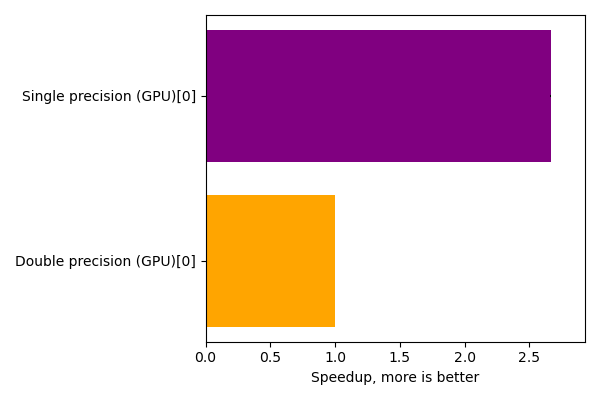

In [6]:
for label in [f'Double precision (GPU)[{gpu_id}]', 
              f'Single precision (GPU)[{gpu_id}]']:
    timings.add_result(benchmark[label], label)

timings.plot_results("Single precision")

Timing results for the GPU show that moving to 32-bit has resulted in significantly faster kernel execution time. 

#### Conclusions from precision

Unless your algorithm **requires** high precision then using lower precision numbers can improve compute performance on most compute devices. This is because memory bandwidth requirements are lower, and the hardware may be more optimised for lower precision compute.

### Block size optimisation and coalesced memory access

Performance is a complicated function that is dependent on the performance of the processor and how efficiently cache lines are being used. Block (workgroup) size is a way to **influence** how many thread teams participate in a block, and this has an effect on how compute devices access memory. 

Using the flag **plot=True**, we inspect the landscape of runtimes for single precision matrix multiplication as a function of block size along each axis. In the plot `blockDim.x` is mapped to dimension 1 of the matrices, and `blockDim.y` is mapped to dimension 0 of the matrices.

Min time is 1.237 ms, at the local size of (32,16,1).
Max time is 59.248 ms, at the local size of (1,1,1).
Max time / min time == 47.892


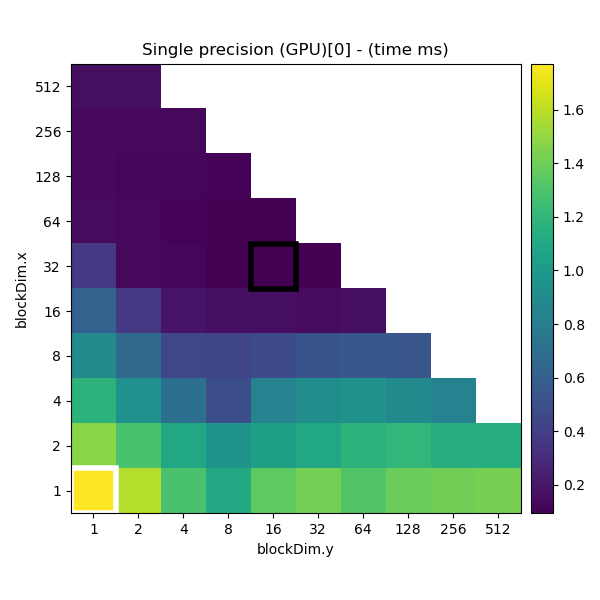

In [7]:
for label in [f'Single precision (GPU)[{gpu_id}]']:
    timings.add_result(benchmark[label], label, plot=True)

From the graph it seems that the best performing block size is one where there is an elongated number of threads in `blockDim.x`, which corresponds to dimension 1 of the matrices. If we overlay a cartoon of access to cache lines on the matrix multiplication we see that reasonably efficient cache usage is taking place along the rows of **A** because threads along row i0 have the potential to reuse parts of a cache line and the inner loop for the dot product uses adjacent memory locations. It may seem counterintuitive, but **even more efficient** cache usage is **taking place** for memory access along the columns of **B** because as we loop along the columns of **B**, cache lines are being **completely shared** by their neighbouring threads along dimension 1. 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/coalesced_memory_access.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Cache line use in matrix multiplication.</figcaption>
</figure>

When looping over arrays in kernels it might seem counterintuitive to loop over dimensions with the greatest stride. However if you ensure that neighbouring threads read or write to neighbouring elements in an array then you can make use of coalesced memory access. 

### Constant memory

We saw in the [Memory Management](../L6_Memory_Management/Memory.ipynb) module that **constant** memory is stored in a fast cache on the compute device. This storage space is small, on the order of a few tens to a few hundred kilobytes in size. Constant memory is read-only from the kernel, writable from the host, and is a good storage place for filter coefficients, such as is used for finite difference and convolution operations. We can't really use constant memory for matrix multiplication though.

### Rearranging memory for better access

Sometimes there can be a performance benefit if we rearrange memory prior to kernel launch and leverage more optimal memory access patterns. We saw in the local size optimisation section that coalesced memory access is still possible with accesses to matrix B, however we would like to know if that memory access more or less optimal than that of A?

#### Transpose B

Transposing is swapping the rows and columns of a matrix, row i0 of the matrix becomes column i0 and so forth. We might be able to leverage better cache reuse by first transposing matrix **B** to make **BT**, so that memory access occurs along the rows of **A** and **BT**.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_transpose.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Transposed matrix multiplication.</figcaption>
</figure>

Min time is 2.173 ms, at the local size of (8,128,1).
Max time is 73.413 ms, at the local size of (1,1,1).
Max time / min time == 33.791


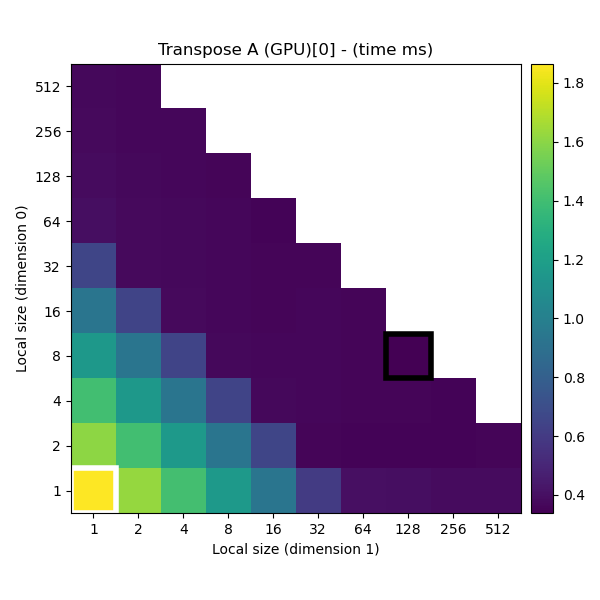

Min time is 5.023 ms, at the local size of (8,128,1).
Max time is 57.999 ms, at the local size of (1,1,1).
Max time / min time == 11.547


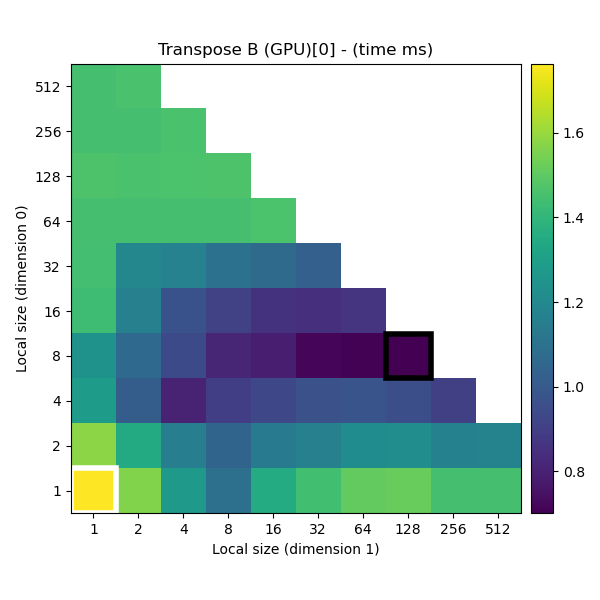

In [8]:
for label in [f"Transpose A (GPU)[{gpu_id}]",f"Transpose B (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label, plot=True)

For the CPU result there is no clear global minimum for local size when B is transposed. This suggests that memory access is largely indepdendent between threads. Each thread has its own set of cache lines to walk across, so it doesn't matter how big the local size is. For the GPU result there is a clearly defined global minimum at a workgroup size of (8,32) or 256 work-items, which translates to (32,8) in the coordinate system of the matrices. Larger workgroup sizes such as 256 permit a large number of active thread teams, which is good for occupancy. Let's see how the timing results go.

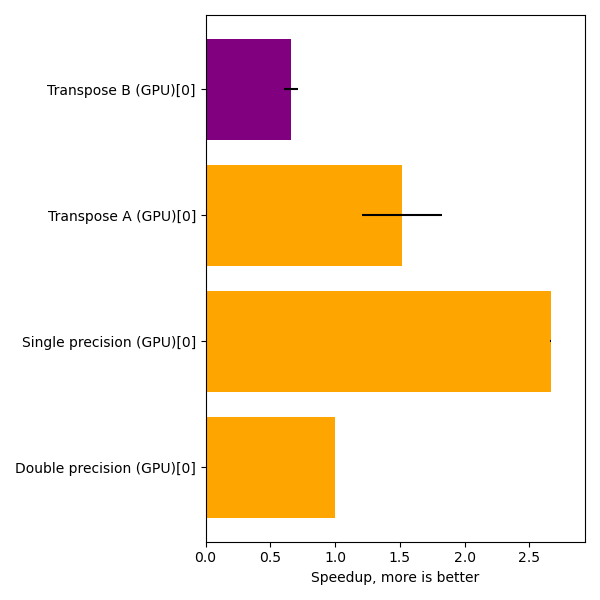

In [9]:
timings.plot_results("Transpose B")

From the peformance results above, transposing B has had a **positive** effect on the CPU but a **detrimental** effect on the GPU. This is because coalesced memory access (where neighbouring work items shared memory in a cache line) is not occuring. The performance effect of transposing memory is behaving in ways that depend on what type of compute device is used.

#### Transposing A

Let's try transposing A instead. Then we hope to get better performance on the GPU through coalesced access. We anticipate worse performance on the CPU as a result.

In transposing A there is no clear minimum in the CPU result because all memory access is non-optimal. In the GPU result however it looks like all of the larger workgroup sizes do well.

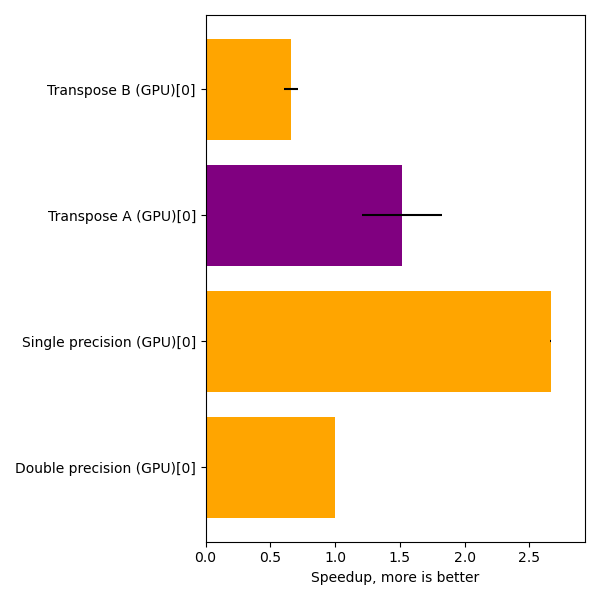

In [10]:
timings.plot_results("Transpose A")

Interestingly, the timing results from transposing A show that it is not as performant as best performing algorithm thus far ("Single precision"). This implies a limit to the amount of coalesced access that can take place.

### Local memory

On GPU's local memory uses local cache with a much lower latency than fetches from global memory. In the <a href="../L6_Memory_Management/Memory.ipynp">Memory Management Lesson</a> we implemented matrix multiplication implementation that **naively** copies all of the needed columns of B for a workgroup into local memory. 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_local.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

We try two different scenarios where we use shared memory to store entire columns of B or entire rows of A for a workgroup. Here is the kernel for the scenario where we cache columns of B into local memory.

```C++
// Matrix multiply kernel that uses local memory for B
__kernel void mat_mult_local_B (
                        __global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
    
    // A is of size (N0_C, N1_A)
    // B is of size (N1_A, N1_C)
    // shared_B is of size (L1, N1_A)
    // C is of size (N0_C, N1_C)
    
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(1); 
    size_t i1=get_global_id(0); 
    
    // Location within the workgroup
    size_t s0=get_local_id(1);
    size_t s1=get_local_id(0);
    
    // Local size
    size_t L0=get_local_size(1);
    size_t L1=get_local_size(0);
    
    // start and end
    size_t start, end;
    
    // Fill shared_B
    
    // Get the start and end lengths
    get_start_end(L0, N1_A, s0, &start, &end);
    // Fill the columns of shared with B
    if (i1<N1_C) {
        for (size_t n=start; n<end; n++) {
            shared_B[s1*N1_A+n]=B[i1+n*N1_C]; 
        }
    }
    
    // Enqueue a local barrier to make sure all the work items finish
    barrier(CLK_LOCAL_MEM_FENCE);
    
    // Scratch variable
    float temp=0.0f; 
    
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // shared_B is of size (L1, N1_A)
            // C is of size (N0_C, N1_C)
            
            // Loop across row i0 of A
            // and across row s1 of shared_B
            temp+=A[i0*N1_A+n]*shared_B[s1*N1_A+n]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
}
```

The CPU solution was not available for this test as the CPU OpenCL implementation did not allow so much shared memory to be allocated.

Min time is 1.180 ms, at the local size of (128,8,1).
Max time is 136.690 ms, at the local size of (1,1,1).
Max time / min time == 115.874


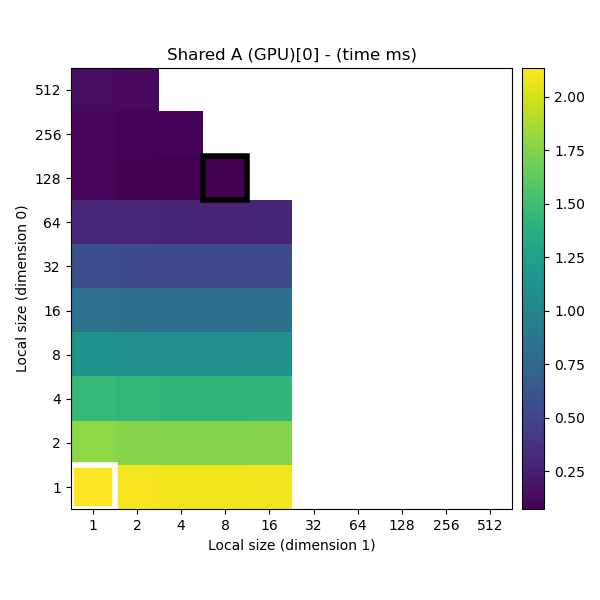

Min time is 2.129 ms, at the local size of (8,64,1).
Max time is 199.707 ms, at the local size of (1,1,1).
Max time / min time == 93.823


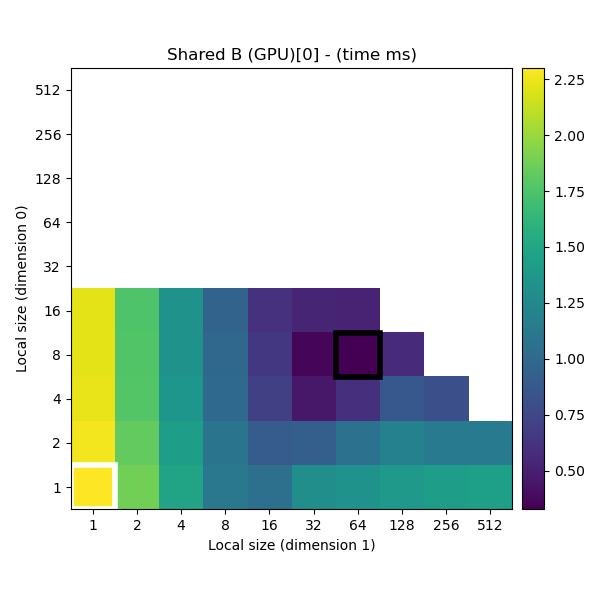

In [11]:
for label in [f"Shared A (GPU)[{gpu_id}]",f"Shared B (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label, plot=True)

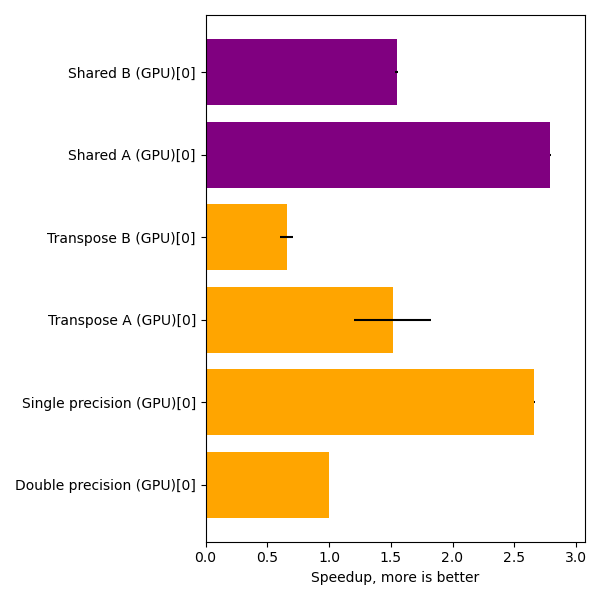

In [12]:
timings.plot_results("Shared")

From the GPU results, it appears that both shared memory implementations favoured workgroups where the number of rows in shared memory is small, typically 2-4 rows wide. The algorithm where rows of A are shared (instead of columns of B) produced the best results, presumably because access from B is coalesced. There was also a large number of failed experiements because the amount of shared memory to be allocated was too large. Due to shared memory limits this algorithm is performant but **unsuitable** for large matrices.

### Tiled memory access

In order to use local memory effectively in workgroups we need to reduce shared memory usage. We divide up the axis **N1_A** of **A** and **B** into tiles/chunks of size **chunk_len**, then we have the option of reading tiles into shared memory from either **A**, **B** or both. A fixed chunk length is good for performance because we can make **chunk_len** a multiple of elements in a cache line. The number of chunks along the **N1_A** axis (N1_A_c) is **N1_A_c = N1_A/chunk_len**, and we pad the **N1_A** axis with zeros so that an integer number of chunks fits into axis **N1_A**. Each work-item in a workgroup iterates over the number of chunks together, and if the local size is **(L0, L1)** then the allocations of local memory for **A** and **B** are of size **(L0, chunk_len)** and **(L1, chunk_len)** respectively. Each completed chunk (along row **i0** of **A** and row **i1** of **B** represents a partial dot product along the N1_A axis, and work items each use a register to accumulate the sum for placement into **C** at position (i0, i1).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_tile.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Matrix multiplication with chunked domain decomposition.</figcaption>
</figure>

Here is the source code for the tiled kernel in [mat_mult_tile_local_AB.cpp](mat_mult_tile_local_AB.cpp). Local memory is reused for each chunk. Notice that we also have to place a second barrier call after each chunk is completed to make sure that all work items in a work group are in sync before moving to the next chunk.

```C++
// source code in kernels_mat_mult.c

// Matrix multiply kernel that uses local memory in a tiling way
__kernel void mat_mult_tile_local_AB (
                        __global float* A_star, 
                        __global float* B_star, 
                        __global float* C,
                        __local float* shared_A_star,
                        __local float* shared_B_star,
                        unsigned int N1_A_star, 
                        unsigned int N0_C,
                        unsigned int N1_C,
                        unsigned int chunk_len,
                        unsigned int start_chunk_id,
                        unsigned int end_chunk_id) { 
    
    // A_star is of size (N0_C, N1_A_star), (i0, n)
    // B_star is of size (N1_A_star, N1_C), (n, i1)
    // C is of size (N0_C, N1_C), (i0, i1)
    
    // i1 and i2 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i1=min(get_global_id(0), (size_t)N1_C-1); // Fastest dimension
    size_t i0=min(get_global_id(1), (size_t)N0_C-1); 
    
    // shared_A_star is of size (L0, chunk_len) (s0, n)
    // shared_B_star is of size (L1, chunk_len) (s1, n)
    size_t L0 = get_local_size(1); // Slowest dimension
    size_t L1 = get_local_size(0); // Fastest dimension
    
    // index within local memory
    size_t s0 = get_local_id(1); // Slowest dimension
    size_t s1 = get_local_id(0); // fastest dimension
    
    // Positions within shared memory
    __local float* shared_A_star_s0 = &shared_A_star[s0*chunk_len];
    __local float* shared_B_star_s1 = &shared_B_star[s1*chunk_len];

    // Scratch variable
    float temp=0.0f;

    // Start and end positions to copy within a chunk
    size_t start0, end0, start1, end1;
    get_start_end(L1, chunk_len, s1, &start1, &end1);
    get_start_end(L0, chunk_len, s0, &start0, &end0);

    // Loop over the chunks
    for (int chunk_id=start_chunk_id; chunk_id<end_chunk_id; chunk_id++) {

        // Fetch local memory into shared_A_star and shared_B_star
        
        // Starting positions for the copy
        __global float* A_star_i0 = &A_star[i0*N1_A_star+chunk_id*chunk_len];
        __global float* B_star_i1 = &B_star[chunk_id*chunk_len*N1_C+i1];
          
        // Fill the rows of shared_A_star and shared_B_star
        // Copy from row i0 of A_star
        for (size_t n = start1; n<end1; n++) {
            shared_A_star_s0[n] = A_star_i0[n];
        }
        
        // Copy from column i1 of B_star   
        for (size_t n = start0; n<end0; n++) {
            shared_B_star_s1[n] = B_star_i1[n*N1_C];
        }
              
        // Enqueue a local barrier to ensure shared memory is filled
        barrier(CLK_LOCAL_MEM_FENCE);

        // Loop over columns of A and rows of B 
        for (size_t n=0; n<chunk_len; n++) {
                
            // Perform the dot product using local memory
            temp+=shared_A_star_s0[n]*shared_B_star_s1[n];
        }
        
        // Enqueue a local barrier to ensure all work items 
        // are ready to tackle the next tile
        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Put the accumulated value into position
    C[i0*N1_C+i1]=temp;
}

```


Let's see how the performance goes with caching the tiles for A, B and then both A and B in local memory.

In [13]:
for label in [f"Tile shared AB (GPU)[{gpu_id}]",
              f"Tile shared A (GPU)[{gpu_id}]",
              f"Tile shared B (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)

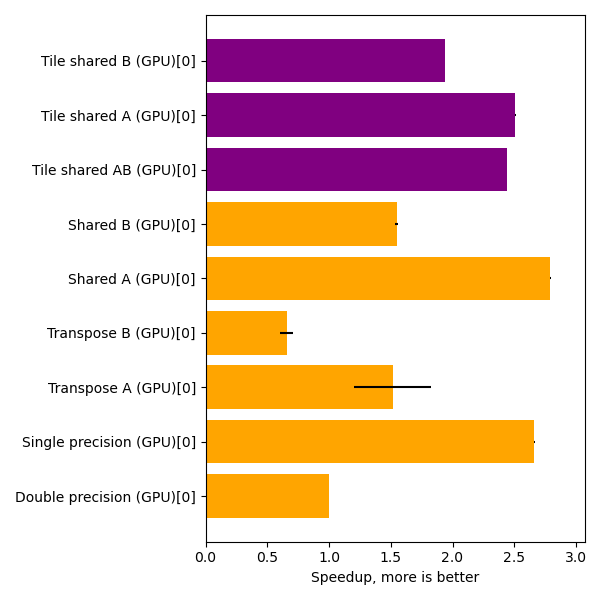

In [14]:
timings.plot_results("Tile shared")

On the CPU the tiled approach with local cache has provided the best performance so far, with caching tiles of **B** in local memory providing the best approach. On the GPU the tiled approach isn't as performant as using local memory for an entire row of A, but caching A in local memory is again the best performer in the tiled category.

### Vectors

Now we see if we can increase performance further by using vectors of type **float8**. For GPU vendors such as Intel and AMD, whose compute units can utilise vector instructions, this can provide a boost in performance. Other implementations, such as NVIDIA's, can still benefit from cache performance increases because vector loads from memory can be optimised. Here we show the kernel code from [mat_mult_tile_local_A_vector.cpp](mat_mult_tile_local_A_vector.cpp) that stores a tile from A into local memory then uses **float8** vectors to perform the partial dot products. We need to sum over the accumulated vector **temp** at the end in order to put the result into **C**.

```C++
// Matrix multiply kernel that uses local memory
__kernel void mat_mult_tile_local_A_vector (
                        __global float* A_star, 
                        __global float* B_star, 
                        __global float* C,
                        __local float8* shared_A_star,
                        unsigned int N1_A_star, 
                        unsigned int N0_C,
                        unsigned int N1_C,
                        unsigned int chunk_len,
                        unsigned int start_chunk_id,
                        unsigned int end_chunk_id) { 

    // Remember that stride for shared arrays is chunk_len_v
    size_t vector_len = 8;
    size_t chunk_len_v = chunk_len / vector_len;
    
    // A_star is of size (N0_C, N1_A_star), (i0, n)
    // B_star is of size (N1_A_star, N1_C), (n, i1)
    // C is of size (N0_C, N1_C), (i0, i1)
    
    // i1 and i2 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i1=min(get_global_id(0), (size_t)N1_C-1); // Fastest dimension
    size_t i0=min(get_global_id(1), (size_t)N0_C-1); 
    
    // shared_A_star is of size (L0, chunk_len) (s0, n)
    // shared_B_star is of size (L1, chunk_len) (s1, n)
    size_t L0 = get_local_size(1); // Slowest dimension
    size_t L1 = get_local_size(0); // Fastest dimension
    
    // index within local memory
    size_t s0 = get_local_id(1); // Slowest dimension
    size_t s1 = get_local_id(0); // fastest dimension
    
    // Positions within shared memory
    __local float8* shared_A_star_s0 = &shared_A_star[s0*chunk_len_v];

    // Scratch variable to accumulate the sum
    float8 temp=(float8)0.0f, scratch=(float8)0.0f;
    size_t offset=0;

    // Start and end positions to copy within a chunk
    size_t start1, end1;
    get_start_end(L1, chunk_len_v, s1, &start1, &end1);

    // Loop over the chunks
    for (int chunk_id=start_chunk_id; chunk_id<end_chunk_id; chunk_id++) {

        // Fetch local memory into shared_A_star and shared_B_star
        
        // Starting positions for the copy
        __global float* A_star_i0 = &A_star[i0*N1_A_star+chunk_id*chunk_len];
        __global float* B_star_i1 = &B_star[chunk_id*chunk_len*N1_C+i1];
          
        // Fill the rows of shared_A_star and shared_B_star
        // From row i0 of A_star
        for (size_t n = start1; n<end1; n++) {
            // Use a vector load function to load data
            shared_A_star_s0[n] = vload8(n, A_star_i0);
            // Otherwise we do this
            //offset = n*vector_len;
            //scratch.s0 = A_star_i0[0+offset]; 
            //scratch.s1 = A_star_i0[1+offset]; 
            //scratch.s2 = A_star_i0[2+offset]; 
            //scratch.s3 = A_star_i0[3+offset]; 
            //scratch.s4 = A_star_i0[4+offset]; 
            //scratch.s5 = A_star_i0[5+offset]; 
            //scratch.s6 = A_star_i0[6+offset]; 
            //scratch.s7 = A_star_i0[7+offset];
            //shared_A_star_s0[n]=scratch;
        }
              
        // Enqueue a local barrier to ensure shared memory is filled
        barrier(CLK_LOCAL_MEM_FENCE);
        
        // Dot product using shared_A_star and B 
        for (size_t n=0; n<chunk_len_v; n++) {
            // Offset into B_star_i1
            offset=n*vector_len*N1_C;
            scratch.s0 = B_star_i1[offset+0*N1_C];
            scratch.s1 = B_star_i1[offset+1*N1_C];
            scratch.s2 = B_star_i1[offset+2*N1_C];
            scratch.s3 = B_star_i1[offset+3*N1_C];            
            scratch.s4 = B_star_i1[offset+4*N1_C];
            scratch.s5 = B_star_i1[offset+5*N1_C];
            scratch.s6 = B_star_i1[offset+6*N1_C];
            scratch.s7 = B_star_i1[offset+7*N1_C];
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=shared_A_star_s0[n]*scratch;
        }
        
        // Enqueue a local barrier to ensure all work items 
        // are ready to tackle the next tile
        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Put the accumulated value into position
    C[i0*N1_C+i1]=temp.s0 + temp.s1 + temp.s2 + temp.s3
        + temp.s4 + temp.s5 + temp.s6 + temp.s7;
}
```

Let's see how these algorithms perform!

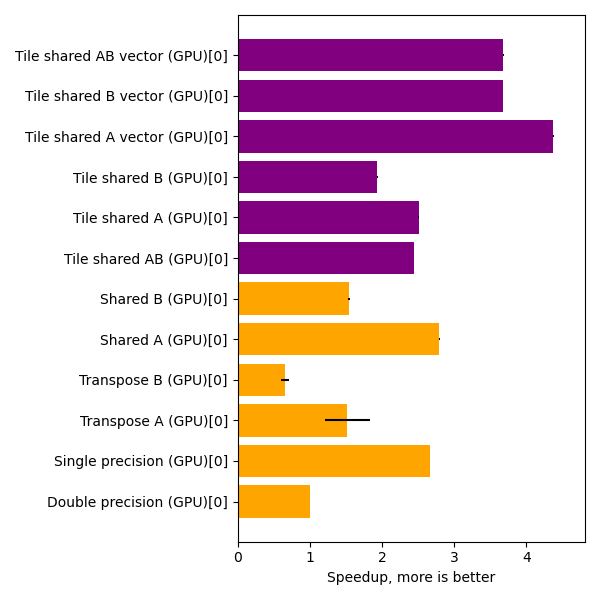

In [16]:
for label in [f"Tile shared A vector (GPU)[{gpu_id}]",
              f"Tile shared B vector (GPU)[{gpu_id}]",
              f"Tile shared AB vector (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)

timings.plot_results("Tile shared")

The use of local memory to cache tiles and vectors to crunch the numbers has a **significant impact**  on the performance of these algorithms, with a 3-4x gain on the best performing CPU results (Tile local A) and a 1.4x gain on the GPU results (Local A). It is interesting to note that local memory caching preferences have completely diverged. The CPU implementation prefers that tiles of **B** are cached in local memory, whereas the GPU implementation prefers tiles of **A** to be cached. Thus if these algorithms were to be used for production one might choose to **cache tiles of A** on GPU's and **cache tiles of B** on CPU's.

### Pre-existing implementations

* In order to use HIPBlas with a CUDA backend it needs to be compiled with CUDA backend. The default hipblas that comes with ROCM only supports AMD backends.

If your problem can be transformed to a linear algebra operation then there are a few solvers available that work with OpenCL. [CLBlast](https://cnugteren.github.io/clblast/clblast.html) is a tunable linear algebra library from Cedtric Nugteren. It has a routine (Sgemm) for the generalised matrix multiplication operation on single precision data.

$$
\alpha \textbf{A} \cdot \textbf{B} + \beta \textbf{C} = \textbf{C}
$$

If we set $\alpha=1.0$ and $\beta=0.0$ then we have the equivalent matrix multiplication that we are using here. In order to use CLBlast we include the header in the program [mat_mult_clblast.cpp](mat_mult_clblast.cpp) we include the CLBlast header

```C
// Include the CLBLAST library
#include <clblast_c.h>
```
Then we call the CLBlast routine **CLBlastSgemm** to perform the matrix multiplication as follows:

```C
        CLBlastStatusCode status = CLBlastSgemm(
            // Choose row-major ordering
            CLBlastLayoutRowMajor,
            // Do we transpose A?
            CLBlastTransposeNo,
            // Do we transpose B?
            CLBlastTransposeNo,
            // Number of rows in C (rows in A) to compute
            (const size_t)NROWS_C,
            // Number of columns in C (columns in B) to compute
            (const size_t)NCOLS_C,
            // Number of columns in A (rows in B) to compute
            (const size_t)NCOLS_A,
            alpha,
            // Buffer, starting offset in elements, length of contiguous dimension
            buffer_A, 0, (const size_t)NCOLS_A,
            buffer_B, 0, (const size_t)NCOLS_C,
            beta,
            buffer_C, 0, (const size_t)NCOLS_C,
            &command_queue,
            &kernel_event
        );
```

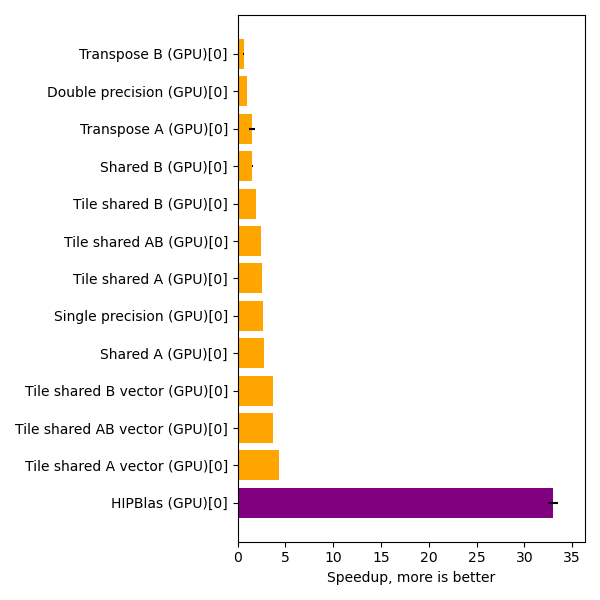

In [26]:
for label in [f"HIPBlas (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)
timings.plot_results("HIPBlas", sort=True)

The tuned `CLBLAST` implementation on the GPU has similar performance to the `Tile local A vector` algorithm, whereas on the CPU it is in third place. Canned solvers have been worked over by experts and usually get the best (or close to the best!) out of your compute hardware. It should be the first choice if your compute problem can handle it.

### Multiple compute devices

If your problem is parallelisable then you can divide work amongst the available compute devices. In matrix multiplication the work is parallelisable in the domain of C. For a matrix **C** of size (N0_C, N1_C) we divide it into (D0, D1) subdomains and use the best-performing **CLBlast** implementation to compute the matrix multiplication work for each subdomain.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/domain_decomposition.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Parallelism achived by dividing the domain of matrix C. Every available compute device is responsible for at least one domain.</figcaption>
</figure>

We use OpenMP dynamic scheduling to create a work queue of subdomains. Subdomains are then mapped to available threads and compute devices. We use the [clEnqueueReadBufferRect](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBufferRect.html) routine to copy the subdomain back to the host memory in **array_C**. Let's see how performance goes with 16 domains and 8 GPU's.

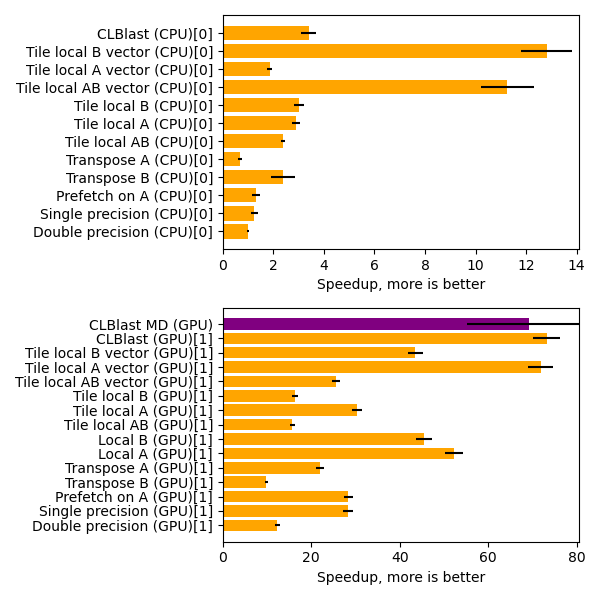

In [24]:
for label in [f"CLBlast MD (GPU)"]:
    timings.add_result(benchmark[label], label)
timings.plot_results("CLBlast MD (GPU)")

Performance using multiple devices and domain decomposition has been suboptimal with this matrix size. It is anticipated though that this is the result of kernel times being much lower than OpenCL overheads. With larger grid sizes we might expect the peformance of a multi-device implementation to improve.

### Summary

Let's plot the timing results again, this time we order by ascending speedup. This is for Setonix.

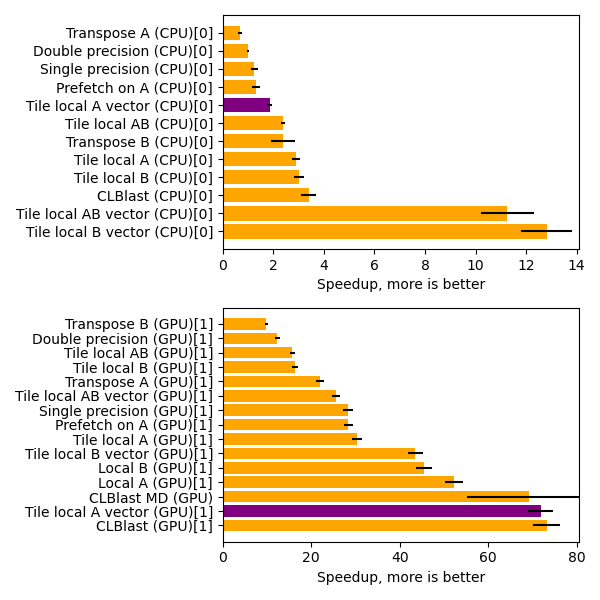

In [25]:
for label in [f"CLBlast MD (GPU)"]:
    timings.add_result(benchmark[label], label)
timings.plot_results("Tile local A vector", sort=True)

On another computer these performance figures may be different, here are the results on my laptop. Note these numbers are relative to the double precision CPU implementation on Setonix.

* CPU 0 - AMD Ryzen 7 6800H
* GPU 0 - integrated Radeon 680M APU
* GPU 1 - NVIDIA RTX 3060

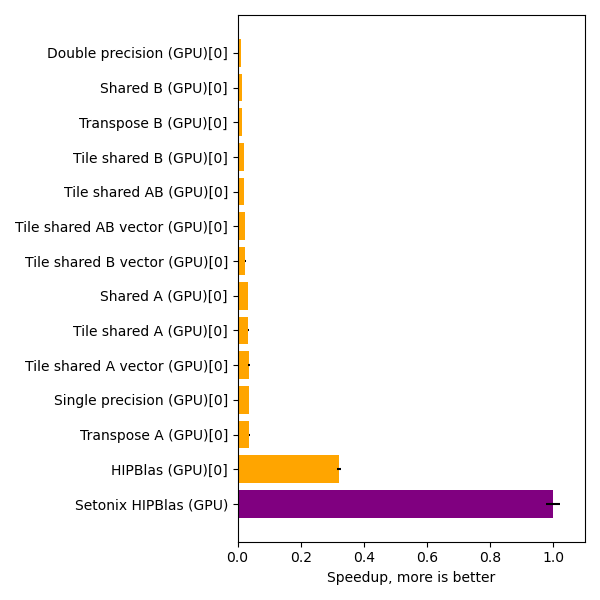

In [28]:
# Benchmark for the laptop
timings_laptop=py_helper.TimingResults()
benchmark_laptop=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "laptop.json"))
timings_laptop.add_result(benchmark['HIPBlas (GPU)[0]'], "Setonix HIPBlas (GPU)")
for label in benchmark_laptop:
    timings_laptop.add_result(benchmark_laptop[label], label)
    
timings_laptop.plot_results("Setonix HIPBlas (GPU)", sort=True)

Here are the performance numbers for my workstation. Note these numbers are relative to the double precision CPU implementation on Setonix.

* CPU 0 - 11th Gen Intel(R) Core(TM) i9-11900KB
* GPU 0 - Intel integrated UHD graphics
* GPU 1 - AMD Radeon VII 

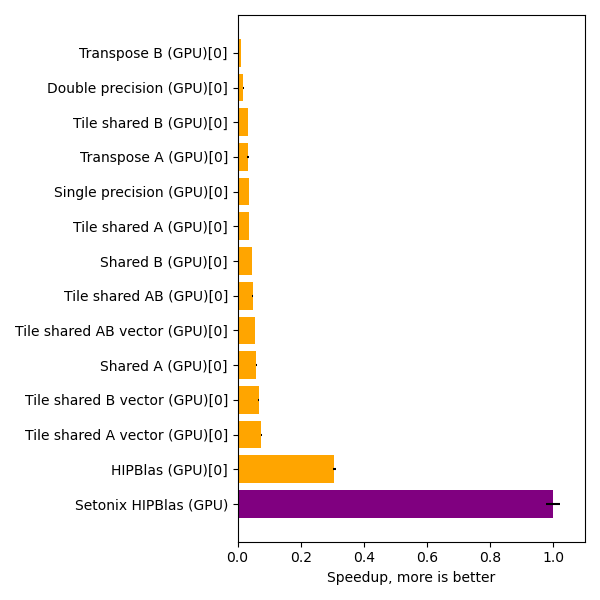

In [29]:
# Benchmark for the Workstation
benchmark_work=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "workstation.json"))
timings_work=py_helper.TimingResults()
timings_work.add_result(benchmark['HIPBlas (GPU)[0]'], "Setonix HIPBlas (GPU)")

for label in benchmark_work:
    timings_work.add_result(benchmark_work[label], label)
timings_work.plot_results("Setonix HIPBlas", sort=True)

We can distill the learnings from this exploration into a collection of principles that will help you get the best out of your OpenCL kernels.

* A **cache line** is the fundmental unit of memory transactions in a processor. Making best use of cache line contents is the key to good performance in HPC applications.
* GPU's have much greater **memory bandwidth** than GPU's but also much greater **latency**.
* GPU's schedule work in lock-step over teams of hardware threads and mitigate latency using deep pipelines with multiple teams active **at the same time**.
* For GPU's the optimum workgroup size is a **multiple** of the team size.
* **Occupancy** is the ratio of active threads on a compute unit vs the potential number of active threads. 
    * To maximise occupancy:
        * Keep the number of registers used low
        * Keep local memory size low
        * Schedule enough workgroups to keep the pipeline full.
        * Large workgroups work well. Use the recommended workgroup size multiple to make large workgroups with a multiple of thread teams, but still under the workgroup limit.
* Matrix and tensor core computations are **not available** in OpenCL.
* Make sure your code paths do not **diverge** for work-items in a team.
* **Arithmetic intensity** for an algorithm is the ratio of FLOPS computed per Byte of memory transferred. A low FLOPS/Byte ratio means that a computation is limited by memory bandwidth, and that is where optimisation efforts should be focused.
* The lower your **precision** the faster a computation can occur. Consider using 32-bit floating point numbers if you can, particularly on gaming hardware.
* Performance is a nonlinear function of local size. Consider tuning the local size to find the best one for your problem.
    * Usually large workgroups (within limits) perform well
* **Prefetching** memory may be able to help fetch memory before it is needed.
* Use **constant memory** to store coefficients and other small memory allocations.
* Use local memory if you can
    * Fill it in parallel using all the work items.
    * Reuse it many times within a kernel.
    * Keep it small enough to avoid occupancy issues.
* Re-arranging memory (such as transposing) prior to kernel execution might be helpful for leveraging coalesced memory access. 
* Using vectors is **essential** for gettting the best performance on compute devices with SIMD units.
* If you can leverage someone else's solver it is a shortcut to gettting good performance.
* Dividing your problem into subdomains and using multiple compute devices to solve each domain **might** provide a performance benefit if other overheads are small.

### Further reading

There are even faster matrix multiplication optimisations, the [OpenCL SGEMM](https://cnugteren.github.io/tutorial/pages/page1.html) tutorial is a great resource for further optimisation of the matrix multiplication problem.

#### Vendor-specific OpenCL optimisation guides

* [NVIDIA OpenCL Best Practices Guide](https://www.nvidia.com/content/cudazone/CUDABrowser/downloads/papers/NVIDIA_OpenCL_BestPracticesGuide.pdf)
* [AMD OpenCL Optimisation Guide](https://rocmdocs.amd.com/en/latest/Programming_Guides/Opencl-optimization.html)
* [Intel OpenCL Optimisation Guide](https://www.intel.com/content/www/us/en/develop/documentation/iocl-opg/top.html)

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Research Centre</a>. All trademarks mentioned are the property of their respective owners.
</address>